In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def f(**kw):
    x = kw['test:y']
    return 20*np.sin(x) - x**2

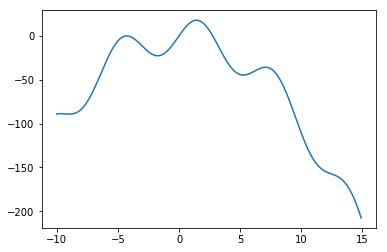

In [3]:
x = np.arange(-10, 15, 0.1)
y = f(**{'test:y':x})
plt.plot(x,y)
plt.show()

In [4]:
from scipy import optimize

In [5]:
optimize.minimize(lambda x:-f(**{'test:y':x}),0)

      fun: -17.75725653147415
 hess_inv: array([[0.0458861]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 14
      nit: 6
     njev: 7
   status: 0
  success: True
        x: array([1.42755177])

In [6]:
from bayes_opt import BayesianOptimization, UtilityFunction

In [7]:
optimizer = BayesianOptimization(f, {'test:y':(-10,15)})
utility = UtilityFunction(kind="ucb", kappa=2.5, xi=0.0)

In [8]:
optimizer.maximize(init_points=5, n_iter=5)

|   iter    |  target   |  test:y   |
-------------------------------------
|  1        | -163.5    |  13.3     |
|  2        | -65.39    |  8.79     |
|  3        | -42.19    |  4.711    |
|  4        | -42.39    |  7.897    |
|  5        | -9.336    | -0.4731   |
|  6        | -8.509    | -5.155    |
|  7        | -89.12    | -10.0     |
|  8        | -13.8     | -2.855    |
|  9        |  17.42    |  1.603    |
|  10       |  4.938    |  2.537    |


In [9]:
for _ in range(10):
    next_point_to_probe = optimizer.suggest(utility)
    #print("Next point to probe is:", next_point_to_probe)
    
    target = f(**next_point_to_probe)
    #print("Found the target value to be:", target)

    optimizer.register(
        params=next_point_to_probe,
        target=target,
    )

|  11       |  15.4     |  0.9533   |
|  12       |  17.68    |  1.344    |
|  13       |  17.76    |  1.439    |
|  14       |  17.76    |  1.432    |
|  15       |  17.76    |  1.432    |
|  16       |  17.76    |  1.431    |
|  17       |  17.76    |  1.43     |
|  18       |  17.76    |  1.432    |
|  19       |  17.76    |  1.43     |
|  20       |  17.76    |  1.427    |


In [10]:
optimizer.max

{'params': {'test:y': 1.4274050152174063}, 'target': 17.757256296746803}

In [11]:
from mod.asyncpv import AsyncPV as PV
from mod.simulator import Simulator, Optimizer

In [12]:
from mod.onlineAlgorithms import OnlineBayesian

In [13]:
# connect to the epics pv
x = PV('test:x')
y = PV('test:y')
sigopt = PV('sig:optim')
sigmodel=PV('sig:calc')

In [14]:
def model(*args,**kw):
    # return a single float number or a list of that(required by `Simulator`)
    # mimic physical device
    if args:
        x = args[0]
    elif kw:
        x = kw['test:x']
    return 20*np.sin(x) - x**2 + np.random.randn()

In [15]:
# define the virtual model
sim = Simulator([x], [y], sigmodel, model)

In [16]:
# the objective function that will accept both x and y as keyword argument
# and only y will be used here
def objf(**kw) -> float:
    y = kw['test:y']
    return y

In [17]:
algo = OnlineBayesian(objf, {x.pvname:(-10,15)})
optim = Optimizer([x], [y], sigopt, algo)

In [18]:
# initialize signal
sigopt.put(True)
sigmodel.put(False)

1

In [19]:
# make the first value appropriate
x.put(-2.2)
y.put(model(x.get()))

x.get(),y.get()

(-2.2, -39.36781816144753)

In [20]:
def suggest(pvname=None, value=None, char_value=None, **kw):
    # optimizer throw a suggestion
    sigopt.async_put(False)
    # make model ready to recive new input
    sigmodel.async_put(False)

In [21]:
def calc(pvname=None, value=None, char_value=None, **kw):
    # tell model start calculation and put result to relevent pv
    sigmodel.async_put(True)
    # make optimizer ready for next step
    sigopt.async_put(True)
    
#x.add_callback(calc)

In [22]:
import time

In [23]:
for _ in range(20):
    suggest()
    print(time.ctime(), 'suggestion : %.3f'%x.get(), '\t' , end='')
    time.sleep(0.5) # wait for suggestion
    calc()
    time.sleep(0.5) # wait for model calculation
    print('model response : %.3f'%y.get())

Fri Mar  5 19:46:12 2021 suggestion : -2.200 	model response : -67.658
Fri Mar  5 19:46:13 2021 suggestion : -7.173 	model response : -149.808
Fri Mar  5 19:46:14 2021 suggestion : 11.679 	model response : -41.687
Fri Mar  5 19:46:15 2021 suggestion : 7.951 	model response : -160.169
Fri Mar  5 19:46:16 2021 suggestion : 12.980 	model response : -23.459
Fri Mar  5 19:46:17 2021 suggestion : 3.574 	model response : 12.410
Fri Mar  5 19:46:18 2021 suggestion : 0.782 	model response : -88.116
Fri Mar  5 19:46:19 2021 suggestion : -10.000 	model response : 18.101
Fri Mar  5 19:46:20 2021 suggestion : 1.752 	model response : 18.904
Fri Mar  5 19:46:21 2021 suggestion : 1.367 	model response : 17.573
Fri Mar  5 19:46:23 2021 suggestion : 1.524 	model response : -0.716
Fri Mar  5 19:46:24 2021 suggestion : -4.554 	model response : -42.256
Fri Mar  5 19:46:25 2021 suggestion : 5.904 	model response : -4.321
Fri Mar  5 19:46:26 2021 suggestion : -3.581 	model response : 5.725
Fri Mar  5 19:46:2

In [24]:
sim.destroy()
optim.destroy()